In [16]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import csv

Populating the interactive namespace from numpy and matplotlib


In [17]:
# -- Variable Dictionary --

# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Parameters we are trying to find
omega_m = None                  # mass density parameter
w = None                        # equation of state
dm_offset = None                # offset of the model from the data

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots
npts = None                     # Number of points (omega_m, w) we use

# Calculate Hubble distance
H = 70.0                        # Hubble constant
D_H = c / H                     # Hubble distance

Function dictionary

In [18]:
# Calculate E(z), which in this situation depends on w
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    # Assume a flat universe, i.e. omega_k = 0
    omega_k = 0.0
    inside = omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w))
    if (inside < 0):
        print("inside = " + str(inside))
        print("omega_m = " + str(omega_m))
        print("omega_k = " + str(omega_k))
        print("omega_l = " + str(omega_l))
        print("w = " + str(w))
        print("z_i = " + str(z_i))
    inside = abs(inside)
    E = np.sqrt(inside)
    return E

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, w, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, w, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

# -----------------------------------------------------------------------------------

# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, w, omega_m, omega_l):

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0

    # Calculate D_M/D_H for different universe geometries
    # open universe (omega_k > 0)
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z,w,omega_m,omega_l) )
    # closed universe (omega_k < 0)
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z,w,omega_m,omega_l) )
    # flat universe (omega_k = 0)
    else:
        return 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) )

# proper motion distance for omega_l != 0
def prop_motion(z, w, omega_m, omega_l):
        
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0
    
    # Calculate D_C/D_H integral
    DCDH = DCDH_int(z,w,omega_m,omega_l)
    
    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH )
    # closed universe
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH )
    # flat universe
    else:
        return DCDH

# --------------------------------------------------------------------------------------------

# distance modulus

def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    
    # initialize the distance modulus value
    mu = 0.0
    
    # convert D_H from Mpc to pc
    DH = D_H * 1.0e6
    
    # Determine D_M/D_H
    if (omega_l == 0):
        DMDH = prop_motion_0(z, w, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, w, omega_m, omega_l)

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    
    return mu

In [19]:
# Begin by collecting csv data and making a scatter plot of it
zs = []
dm_obs = []
sigmas = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
    i = 0
    for row in ps1_data:
        if (i > 0):
            zs.append(float(row[1]))
            dm_obs.append(float(row[4]))
            sigmas.append(float(row[5]))
        i+= 1
csvfile.close()

Proposal and log likelihood functions

In [30]:
# proposal function q(x'|x) where x is a 3-component vector
def q(x):
    # single-variable normal distribution sampling for each component, then recombine at the end
    q = []
    for i in range(3):     # q is a 3D vector
        qi = randn()
        q.append(qi)
    print("q = " + str(q))
    return q


In [31]:
# -- Test q(x) --
qchain = [[0.0, 0.0, 0.0]]

for i in range(100):
    qi = qchain[-1]
    qnew = q(qi)
    qchain.append(qnew)
    #print("xnew = " + str(xnew))

q0s = []
q1s = []
q2s = []

for qj in qchain:
    q0s.append(qj[0])
    q1s.append(qj[1])
    q2s.append(qj[2])
    
# find the average of each q-component
print("average of x-components = " + str(np.mean(q0s)))
print("average of y-components = " + str(np.mean(q1s)))
print("average of z-components = " + str(np.mean(q2s)))


q = [2.389766052684105, 0.33243778604519586, 0.15035079416780914]
q = [0.5563807952976827, -0.33550201753917513, -1.2290932486907291]
q = [-0.4192338726685267, 0.5792726981176626, -1.4614267085617776]
q = [-1.152706150089406, -1.2801710232025583, -2.13345715385002]
q = [-0.7069328859993343, -0.06384690739321039, 0.8259135817964706]
q = [-0.1463627680375905, 2.77522473344193, 1.6093141651742537]
q = [-0.05125623512384101, 1.456973441625295, -0.15315796366413195]
q = [0.45421647853513847, -0.28684655084613775, -0.5067498753045439]
q = [-0.3271130870506132, -1.662236379607778, -0.5665678729836835]
q = [0.4206983430693031, -0.9392655030302953, -0.6604432369770126]
q = [-1.0348459593864205, 0.33863371708384504, 0.5340765407501129]
q = [-0.4119690525382681, 0.8664046454773293, -1.2938468455989767]
q = [-1.6358712081054736, -1.0781270361485054, 0.13690535880009153]
q = [-0.029153249212430156, -0.4117108734262617, 0.7091999335410352]
q = [0.07053164321629829, -1.7591970842514792, -0.8940388413

Run MCMC

In [22]:
# Create the lnf function
lnf = make_log_likelihood(zs, dm_obs, sigmas, D_H)

# Markov chain
mchain = [[0.5,-1.0,20.0]]    # array of omega_m, w, and dm_offset values

for i in range(200):
    
    # Take the last entry in the Markov chain
    params = mchain[-1]
    
    omega_m = params[0]
    w = params[1]
    dm_offset = params[2]

    # propose a new point in the parameter space
    params_new = q(params)
    
    omega_m_new = params_new[0]
    w_new = params_new[1]
    dm_offset_new = params_new[2]
    
    print("i = " + str(i))
    print("params = " + str(params))
    print("params_new = " + str(params_new))
    print()
    print("omega_m = " + str(omega_m) + " | w = " + str(w) + " | dm_offset = " + str(dm_offset))
    print("omega_m_new = " + str(omega_m_new) + " | w_new = " + str(w_new) + " | dm_offset_new = " + str(dm_offset_new))
    print()
    # log likelihood is always negative. If lnf_new is greater than lnf_old, then accept_diff is positive
    lnf_new = lnf(omega_m_new, w_new, dm_offset_new)
    lnf_old = lnf(omega_m, w, dm_offset)
    accept_diff = lnf_new - lnf_old
    print("lnf old: " + str(lnf_old))
    print("lnf new: " + str(lnf_new))
    print("accept_diff = " + str(accept_diff))
    
    # accept if the accept_diff is greater than a randomly selected value from 1 to e, reject otherwise
    benchmark = np.log(rand())
    if benchmark < accept_diff:
        mchain.append(params_new)
    else:
        mchain.append(params)
    # Problem: At some point, it gets to where the acceptance difference is 
    
    #if (i % 20 == 0):
    #    print("i = " + str(i))
    
    # print a line to separate results of each iteration
    print()
    print("-----------")
    print()
        
print("Finished MCMC")

q = [-1.33124718  0.04636934 -1.27798572]
i = 0
params = [0.5, -1.0, 20.0]
params_new = [ 0.         -0.95363066 18.72201428]

omega_m = 0.5 | w = -1.0 | dm_offset = 20.0
omega_m_new = 0.0 | w_new = -0.9536306589103108 | dm_offset_new = 18.722014277595743

lnf old: -2505948.118769369
lnf new: -1971506.210972768
accept_diff = 534441.9077966011

-----------

q = [-0.21978897  1.02581062 -1.65279148]
i = 1
params = [ 0.         -0.95363066 18.72201428]
params_new = [ 0.          0.07217996 17.0692228 ]

omega_m = 0.0 | w = -0.9536306589103108 | dm_offset = 18.722014277595743
omega_m_new = 0.0 | w_new = 0.07217996030350327 | dm_offset_new = 17.069222795464288

lnf old: -1962489.6228285863
lnf new: -1251324.681108384
accept_diff = 711164.9417202023

-----------

q = [-1.55161369  1.7551056   0.06057563]
i = 2
params = [ 0.          0.07217996 17.0692228 ]
params_new = [ 0.          1.82728556 17.12979842]

omega_m = 0.0 | w = 0.07217996030350327 | dm_offset = 17.069222795464288
omega_m_new 

lnf old: -20976.325602411012
lnf new: -67113.75408034807
accept_diff = -46137.42847793705

-----------

q = [0.9476407  0.5594558  2.52865794]
i = 21
params = [ 0.26918883  3.99318687 11.86186871]
params_new = [ 1.          4.55264267 14.39052665]

omega_m = 0.2691888302030951 | w = 3.9931868692376318 | dm_offset = 11.861868706914455
omega_m_new = 1.0 | w_new = 4.55264267399388 | dm_offset_new = 14.390526650179003

lnf old: -20976.325602411012
lnf new: -358552.86992910784
accept_diff = -337576.54432669684

-----------

q = [-1.25404974  0.95938157  3.46487593]
i = 22
params = [ 0.26918883  3.99318687 11.86186871]
params_new = [ 0.          4.95256844 15.32674463]

omega_m = 0.2691888302030951 | w = 3.9931868692376318 | dm_offset = 11.861868706914455
omega_m_new = 0.0 | w_new = 4.952568436353995 | dm_offset_new = 15.326744634643786

lnf old: -20976.325602411012
lnf new: -325776.5117060763
accept_diff = -304800.18610366527

-----------

q = [ 1.65288266 -0.53070232  0.34485963]
i = 23
pa

lnf old: -8356.163975179035
lnf new: -27559.340405130104
accept_diff = -19203.17642995107

-----------

q = [ 0.25485531 -0.04339583 -1.40118981]
i = 41
params = [ 0.47714516  2.31687473 11.40679655]
params_new = [ 0.73200047  2.27347889 10.00560674]

omega_m = 0.4771451608000147 | w = 2.316874727368508 | dm_offset = 11.40679655297765
omega_m_new = 0.7320004681686485 | w_new = 2.273478893707893 | dm_offset_new = 10.005606742632901

lnf old: -8356.163975179035
lnf new: -49393.117995258806
accept_diff = -41036.95402007977

-----------

q = [ 0.23813183 -0.59095191  1.05147299]
i = 42
params = [ 0.47714516  2.31687473 11.40679655]
params_new = [ 0.71527699  1.72592282 12.45826954]

omega_m = 0.4771451608000147 | w = 2.316874727368508 | dm_offset = 11.40679655297765
omega_m_new = 0.7152769922467866 | w_new = 1.7259228160401614 | dm_offset_new = 12.458269539881751

lnf old: -8356.163975179035
lnf new: -48562.97688618182
accept_diff = -40206.81291100279

-----------

q = [ 0.73800347 -0.0674

lnf old: -178.72788644635995
lnf new: -7815.927145265271
accept_diff = -7637.199258818911

-----------

q = [-1.33896842 -0.63031895 -0.42643223]
i = 61
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.          0.27982039 10.49691381]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.0 | w_new = 0.2798203880639881 | dm_offset_new = 10.49691380962236

lnf old: -178.72788644635995
lnf new: -18255.287521213177
accept_diff = -18076.559634766818

-----------

q = [ 1.67886175  0.77839585 -1.2253975 ]
i = 62
params = [ 1.          0.91013934 10.92334604]
params_new = [1.         1.68853519 9.69794854]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 1.0 | w_new = 1.6885351946204068 | dm_offset_new = 9.697948541605491

lnf old: -178.72788644635995
lnf new: -41211.21175318721
accept_diff = -41032.483866740855

-----------

q = [ 0.96723263 -1.20783506  2.05262331]
i = 63
params = [ 1.          0.91013934

lnf old: -178.72788644635995
lnf new: -3568.1832638633614
accept_diff = -3389.4553774170013

-----------

q = [-0.08301806  0.56279131  0.3056486 ]
i = 81
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.91698194  1.47293065 11.22899465]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.9169819410944093 | w_new = 1.4729306464072445 | dm_offset_new = 11.228994645408097

lnf old: -178.72788644635995
lnf new: -3211.0534145387874
accept_diff = -3032.3255280924272

-----------

q = [-1.5034552   1.76842877 -0.31427816]
i = 82
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.          2.67856811 10.60906788]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.0 | w_new = 2.6785681118806246 | dm_offset_new = 10.609067881253576

lnf old: -178.72788644635995
lnf new: -13984.844803975791
accept_diff = -13806.11691752943

-----------

q = [-1.13891724  0.49167946  0.30455181]
i = 83
params = [ 

lnf old: -178.72788644635995
lnf new: -11322.000765952438
accept_diff = -11143.272879506078

-----------

q = [0.6579411  0.17991416 0.73714938]
i = 101
params = [ 1.          0.91013934 10.92334604]
params_new = [ 1.          1.0900535  11.66049542]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 1.0 | w_new = 1.0900534956614307 | dm_offset_new = 11.660495422616847

lnf old: -178.72788644635995
lnf new: -17684.2204922986
accept_diff = -17505.49260585224

-----------

q = [-0.16084562 -2.38215929  0.25515797]
i = 102
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.83915438 -1.47201995 11.17850402]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.8391543777163155 | w_new = -1.4720199464550277 | dm_offset_new = 11.178504017252212

lnf old: -178.72788644635995
lnf new: -2246.3396169661746
accept_diff = -2067.6117305198145

-----------

q = [-0.15825382  0.42677705 -0.78706428]
i = 103
params = [ 1

lnf old: -178.72788644635995
lnf new: -112753.51167867507
accept_diff = -112574.78379222871

-----------

q = [ 0.9291532   0.07843301 -1.60133186]
i = 122
params = [ 1.          0.91013934 10.92334604]
params_new = [1.         0.98857235 9.32201418]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 1.0 | w_new = 0.9885723539448258 | dm_offset_new = 9.322014184429072

lnf old: -178.72788644635995
lnf new: -71355.03108361382
accept_diff = -71176.30319716746

-----------

q = [-0.86104256  0.51677866 -0.05681937]
i = 123
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.13895744  1.426918   10.86652667]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.1389574374212459 | w_new = 1.4269180042080252 | dm_offset_new = 10.866526669888273

lnf old: -178.72788644635995
lnf new: -5912.541141504789
accept_diff = -5733.81325505843

-----------

q = [-1.7461528   1.4250628  -1.11527931]
i = 124
params = [ 1.   

lnf old: -178.72788644635995
lnf new: -587.5813053932762
accept_diff = -408.8534189469163

-----------

q = [-2.03203206 -0.27283246 -0.869507  ]
i = 143
params = [ 1.          0.91013934 10.92334604]
params_new = [ 0.          0.63730688 10.05383904]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 0.0 | w_new = 0.6373068836817519 | dm_offset_new = 10.053839040815692

lnf old: -178.72788644635995
lnf new: -42300.23858483435
accept_diff = -42121.51069838799

-----------

q = [ 0.21486141  0.43069474 -0.36800914]
i = 144
params = [ 1.          0.91013934 10.92334604]
params_new = [ 1.          1.34083408 10.5553369 ]

omega_m = 1.0 | w = 0.910139340014156 | dm_offset = 10.923346042675638
omega_m_new = 1.0 | w_new = 1.3408340844938313 | dm_offset_new = 10.555336900302684

lnf old: -178.72788644635995
lnf new: -3300.0089830565203
accept_diff = -3121.28109661016

-----------

q = [ 0.77502258 -0.98245223  1.5689907 ]
i = 145
params = [ 1.          0.910

lnf old: -149.0620184874777
lnf new: -10245.73403134338
accept_diff = -10096.672012855903

-----------

q = [1.27477418 0.02378117 1.81489076]
i = 163
params = [ 1.          0.88317035 10.90647648]
params_new = [ 1.          0.90695153 12.72136724]

omega_m = 1.0 | w = 0.8831703522611141 | dm_offset = 10.906476479044814
omega_m_new = 1.0 | w_new = 0.9069515250079794 | dm_offset_new = 12.721367236196112

lnf old: -149.0620184874777
lnf new: -98503.74462717582
accept_diff = -98354.68260868835

-----------

q = [1.26716579 1.16367522 1.23783763]
i = 164
params = [ 1.          0.88317035 10.90647648]
params_new = [ 1.          2.04684557 12.1443141 ]

omega_m = 1.0 | w = 0.8831703522611141 | dm_offset = 10.906476479044814
omega_m_new = 1.0 | w_new = 2.0468455674392643 | dm_offset_new = 12.144314104253118

lnf old: -149.0620184874777
lnf new: -46400.755145148876
accept_diff = -46251.6931266614

-----------

q = [ 1.47294683 -0.19680114 -0.28885384]
i = 165
params = [ 1.          0.88317035 

lnf old: -137.5540313091479
lnf new: -20167.866744794508
accept_diff = -20030.31271348536

-----------

q = [ 0.99380639 -0.82428813  0.88888935]
i = 183
params = [ 1.          1.16791378 10.89353372]
params_new = [ 1.          0.34362565 11.78242307]

omega_m = 1.0 | w = 1.167913776715933 | dm_offset = 10.893533719439874
omega_m_new = 1.0 | w_new = 0.34362565060252304 | dm_offset_new = 11.782423066040847

lnf old: -137.5540313091479
lnf new: -23634.32666604156
accept_diff = -23496.772634732413

-----------

q = [ 1.88392343 -0.34644213 -0.11859869]
i = 184
params = [ 1.          1.16791378 10.89353372]
params_new = [ 1.          0.82147165 10.77493502]

omega_m = 1.0 | w = 1.167913776715933 | dm_offset = 10.893533719439874
omega_m_new = 1.0 | w_new = 0.8214716491567192 | dm_offset_new = 10.774935024871972

lnf old: -137.5540313091479
lnf new: -487.05497126346256
accept_diff = -349.5009399543147

-----------

q = [-0.41364836 -0.9472898  -1.15715985]
i = 185
params = [ 1.          1.16

In [60]:
# Extract V- and R-coordinates from the array of vectors
omegams = []    # list of omega_m values
ws = []         # list of w values
offsets = []    # list of dm offsets

for i in mchain:
    omegams.append(i[0])
    ws.append(i[1])
    offsets.append(i[2])
    #print("length of each array: " + str(len(omegams)))
    # Variation of the loop: use an if statement to omit burn-in points
    #for i in VRs:
    #

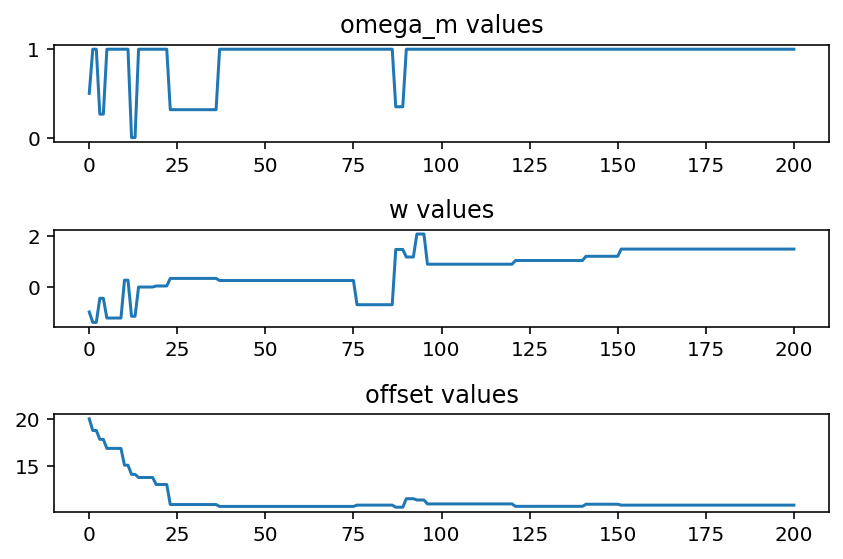

In [48]:
# Trace the evolution of V and R values over iterations
subplot(311)
title('omega_m values')
plot(omegams)

subplot(312)
title('w values')
plot(ws)

subplot(313)
title('offset values')
plot(offsets)

tight_layout()

show()

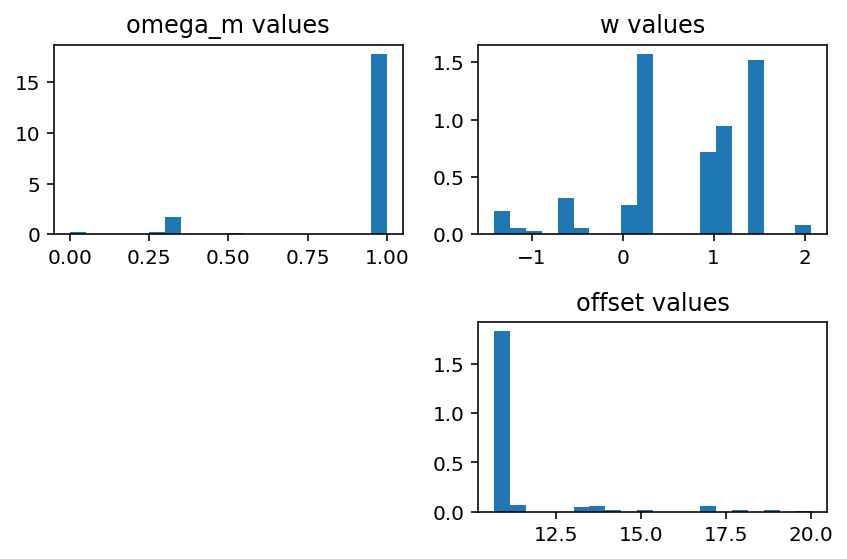

In [49]:
    
# Generate 1-dimensional histograms of parameter values
subplot(221)
title('omega_m values')
hist(omegams, density=True, bins=20)

subplot(222)
title('w values')
hist(ws, density=True, bins=20)

subplot(224)
title('offset values')
hist(offsets, density=True, bins=20)

#subplot(223)
#title('R vs V')
#scatter(Vs, Rs)
#plt.xlabel('V')
#plt.ylabel('R')

tight_layout()

show()